In [1]:
import os
import scanpy as sc
import numpy as np
import multiprocessing
import anndata
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from scipy import sparse
from scipy.stats import norm


/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
path = '/Users/antonogorodnikov/Documents/Work/DataSci/SCITO-seq/tests/100k_pbmc_filtered_feature_bc_matrix.h5'
verbose = True

In [3]:
batchid_string='barcode'

In [4]:
adata = sc.read_10x_h5(path, gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
n_clust=None
batches = adata.var_names.str.extract(r'(%s\d+)'%batchid_string).iloc[:,0].dropna().unique()
nClust = n_clust if n_clust != None else len(batches)+1

In [6]:
ab_adata = adata[:,adata.var_names.str.contains(r'(%s\d+)'%batchid_string)]

/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [7]:
def count_collapser(data, bc):
    '''
    Collapses counts for all antibodies for a given batch barcode. Outputs dense data structure
    :param data: sparse or dense data (AnnData or DataFrame) with counts
    :param bc: batch barcode
    :return: Numpy array of cells by batch BC.
    '''
    #TODO add handle for dense data
    rel_data = data[:,data.var.index.str.contains(r'(%s$)'%bc)]
    collapsed = rel_data.X.toarray().sum(axis=1).astype("int")

    return collapsed

In [8]:
batch_counts = np.transpose(np.array([count_collapser(ab_adata, bc) for bc in batches]))

In [9]:
# create anndata object with collapsed counts per batch
batch_adata = anndata.AnnData(X=sparse.csr_matrix(batch_counts),
                              obs=adata.obs,
                              var=pd.DataFrame(batches, columns=['batch']))

Transforming to str index.


In [10]:
sc.pp.normalize_per_cell(batch_adata, counts_per_cell_after=1e4)
if verbose:
    print("Keeping linear scale data for computing average")
batch_adataNormLin = batch_adata.copy()
sc.pp.log1p(batch_adata)


Keeping linear scale data for computing average


In [12]:
np.transpose(batch_adataNormLin.X.todense())[:10,:10]

matrix([[ 115.27377 ,  157.63168 ,  353.5912  ,  374.20386 ,  390.67422 ,
          398.9704  ,  111.34127 ,  271.3435  ,  566.3717  ,  482.9309  ],
        [3487.0315  ,   76.8935  ,  375.69064 ,  310.50958 ,  378.07184 ,
         3221.7932  , 3125.3235  ,  529.45074 ,  353.9823  ,  324.7294  ],
        [5645.5327  ,  242.21452 ,  685.08295 ,  453.8217  ,  378.07184 ,
         5019.305   , 6183.3247  , 7921.9062  ,  362.83188 ,  274.77103 ],
        [  80.69164 , 2176.0862  ,  254.14366 ,  302.5478  ,  296.15625 ,
          193.05019 ,   82.85862 ,   99.27201 ,  318.58408 ,  233.13907 ],
        [ 187.31989 ,   99.96155 ,  276.2431  ,  222.92995 , 4417.139   ,
          154.44016 ,   88.037285,  145.59895 ,  415.92923 ,  341.3822  ],
        [ 112.39193 , 4736.6396  , 6751.382   ,  374.20386 , 2791.4302  ,
          210.2102  ,  119.10927 ,  218.39842 , 6672.5664  ,  416.31976 ],
        [ 135.44669 ,   99.96155 ,  209.94476 ,  334.39493 ,  384.37302 ,
          227.37022 ,   82.85862

In [13]:
n_clust=None
n_init=100
kfunc="kmeans"
maxneighbor=100
seed=42
keep_input=False

In [14]:
clust_model = KMeans(n_clusters=nClust, n_init=n_init, random_state=seed, n_jobs=int(multiprocessing.cpu_count()*0.6))
clusters = clust_model.fit_predict(batch_adata.X.todense())


In [15]:
clusters

array([8, 0, 0, ..., 6, 2, 5], dtype=int32)

In [16]:
batch_adataNormLin.obs['batch_cluster'] = clusters
batch_adata.obs['batch_cluster'] = clusters
marker_dict = {batch_adataNormLin.var.keys()[0]: batch_adataNormLin.var['batch']} # for average expression of batch oligo

In [17]:
def av_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='batch_cluster'):
    """ Copied from https://github.com/theislab/scanpy/issues/181 - posted by one of scanpy developers
    A function go get mean expressions of feature per cluster (class).
    Data should be normalized to reads per cell, but kept in the linear scale
    #
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'batch_cluster' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = set(anndata.obs[partition_key])
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene)  # Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                anndata.obs[ens_idx[0]] = anndata.X[:, ens_idx].mean(1)  # works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = anndata.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i += 1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return (marker_exp)

In [18]:
av_batch_expr = av_gene_expression(batch_adataNormLin, marker_dict, gene_symbol_key='batch', partition_key='batch_cluster').iloc[:,:-1]


In [19]:
av_batch_expr

,0,1,2,3,4,5,6,7,8,9,10
barcode1,567.818542,572.584351,7315.345703,639.170044,658.644958,787.936829,605.862122,697.706055,589.658386,531.540161,661.398560
barcode2,403.712463,365.898895,290.131531,6800.398438,422.822815,596.413940,407.739563,495.559875,1104.090942,698.992920,419.424042
barcode3,420.233093,394.536194,290.510315,213.341904,455.183960,235.768478,403.912476,500.169617,6303.503906,3974.420166,429.824799
barcode4,344.225983,356.132782,276.558014,347.478546,375.094086,440.154449,307.389069,439.070221,297.071747,326.388702,6139.060547
barcode5,403.679169,498.221130,393.877869,388.606812,413.551941,455.359955,441.515778,5650.886719,342.454132,234.035233,500.947662
barcode6,6608.862305,466.997589,374.311523,424.749023,450.750336,534.868591,410.904938,589.120178,360.014984,387.104767,489.499237
barcode7,429.326477,476.588684,334.599670,390.385529,422.293457,503.745392,6622.096191,529.556091,341.681427,362.186218,476.267670
barcode8,281.824188,310.081482,230.907104,281.479584,6268.324707,489.236542,288.629822,405.205383,258.721405,341.998566,308.328491
barcode9,372.625031,6388.469238,365.356018,379.382019,377.483521,450.924530,347.987305,461.401001,317.568329,309.569763,407.279633
barcode10,167.693115,170.489334,128.402313,135.007675,155.850372,5505.591309,163.962204,231.324722,85.234772,2833.763428,167.969437


In [96]:
discrete = anndata.AnnData(X=sparse.csr_matrix(np.zeros(batch_adata.shape)),
                                   obs=adata.obs,
                                   var=pd.DataFrame(batches, columns=['batch']))

Transforming to str index.


In [97]:
positiveQuantile=0.99

In [88]:
for batch_name in av_batch_expr.index:
    values = batch_adata[:, batch_adata.var['batch'] == batch_name]
    values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name, :])]
    fitty = norm.fit(values_use.X.toarray())
    cutoff = np.quantile(norm.rvs(loc=fitty[0], scale=fitty[1], size=1000, random_state=seed),
                         q=positiveQuantile)

    discrete.X[np.argwhere(values.X > cutoff),
               int(values.var.index[0])] = 1
    if verbose:
        print("Cutoff for {}: {} reads".format(batch_name,
                                               int(np.expm1(cutoff))))

Cutoff for barcode1: 2623 reads
Cutoff for barcode2: 972 reads
Cutoff for barcode3: 657 reads
Cutoff for barcode4: 1039 reads
Cutoff for barcode5: 960 reads
Cutoff for barcode6: 1478 reads
Cutoff for barcode7: 1220 reads
Cutoff for barcode8: 757 reads
Cutoff for barcode9: 1317 reads
Cutoff for barcode10: 258 reads


In [98]:
for batch_name in av_batch_expr.index:
    values = batch_adata[:, batch_adata.var['batch'] == batch_name]
    values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name, :])]
    fitty = norm.fit(values_use.X.toarray())
    cutoff = np.quantile(norm.rvs(loc=fitty[0], scale=fitty[1], size=1000, random_state=seed),
                         q=positiveQuantile)
    
    ox = [x[0] for x in np.argwhere(values.X > cutoff)]

    discrete.X[ox, int(values.var.index[0])] = 1
    if verbose:
        print("Cutoff for {}: {} reads".format(batch_name,
                                               int(np.expm1(cutoff))))

Cutoff for barcode1: 7.872768804164287 reads
Cutoff for barcode2: 6.880468042649393 reads
Cutoff for barcode3: 6.489564777889973 reads
Cutoff for barcode4: 6.947577861394761 reads
Cutoff for barcode5: 6.86825039612727 reads
Cutoff for barcode6: 7.2996733293838565 reads
Cutoff for barcode7: 7.10784933315582 reads
Cutoff for barcode8: 6.631584305811582 reads
Cutoff for barcode9: 7.183961893237171 reads
Cutoff for barcode10: 5.560384990529353 reads


In [99]:
n_positive = np.sum(discrete.X, axis=1)

In [111]:
values.X

<35371x1 sparse matrix of type '<class 'numpy.float32'>'
	with 35348 stored elements in Compressed Sparse Row format>

In [106]:
discrete[np.argwhere(values.X > cutoff), int(values.var.index[0])]

View of AnnData object with n_obs × n_vars = 6907 × 1 
    var: 'batch'

In [100]:
n_positive

matrix([[10.],
        [ 3.],
        [ 2.],
        ...,
        [ 2.],
        [ 1.],
        [ 1.]], dtype=float32)

In [93]:
batch_adata[0,:].obs

,n_counts,batch_cluster
AAACCCAAGAAGTCTA-1,3470.0,8


In [92]:
batch_adata[0,:].X.toarray()

array([[4.7559476, 8.157093 , 8.638797 , 4.4029517, 5.238142 , 4.73085  ,
        4.915934 , 4.4376206, 4.73085  , 3.7219713]], dtype=float32)

In [31]:
for i in range(av_batch_expr.shape[0]):
    batch_name = av_batch_expr.index[i]
    values = batch_adata[:,batch_adata.var['batch'] == batch_name]
    print(batch_name)
    print(values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])].shape)
    print(np.argmin(av_batch_expr.loc[batch_name,:]))

barcode1
(7065, 1)
6
barcode2
(3967, 1)
0
barcode3
(3645, 1)
4
barcode4
(14, 1)
8
barcode5
(13, 1)
10
barcode6
(4622, 1)
5
barcode7
(13, 1)
10
barcode8
(4622, 1)
5
barcode9
(4622, 1)
5
barcode10
(21, 1)
7


/Users/antonogorodnikov/anaconda3/envs/scito/lib/python3.8/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/antonogorodnikov/anaconda3/envs/scito/lib/python3.8/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consid

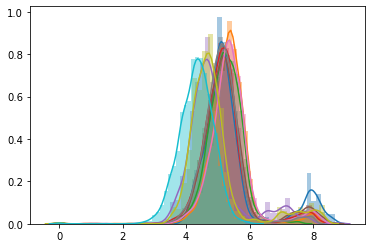

In [118]:
for i in range(av_batch_expr.shape[0]):
    batch_name = av_batch_expr.index[i]
    values = batch_adata[:,batch_adata.var['batch'] == batch_name]
    values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])]
    sns.distplot(values_use.X)

In [24]:
batch_adata.obs['batch_cluster'] = clusters

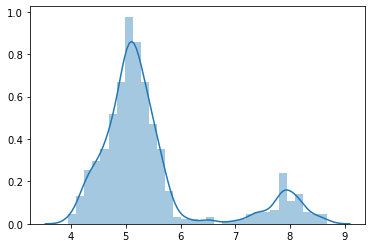

In [105]:
i=0
batch_name = av_batch_expr.index[i]
values = batch_adata[:,batch_adata.var['batch'] == batch_name]
values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])]
sns.distplot(values_use.X)

In [31]:
batch_adata.var

,batch
0,barcode1
1,barcode2
2,barcode3
3,barcode4
4,barcode5
5,barcode6
6,barcode7
7,barcode8
8,barcode9
9,barcode10


In [50]:
discrete = anndata.AnnData(X=sparse.csr_matrix(np.zeros(batch_adata.shape)),
                                   obs=adata.obs,
                                   var=pd.DataFrame(batches, columns=['batch']))

Transforming to str index.


In [51]:
batch_name = 'barcode8'
values = batch_adata[:, batch_adata.var['batch'] == batch_name]
values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name, :])]
fitty = norm.fit(values_use.X.toarray())
cutoff = np.quantile(norm.rvs(loc=fitty[0], scale=fitty[1], size=1000, random_state=seed),
                     q=positiveQuantile)

discrete.X[np.argwhere(values.X > cutoff),
           int(values.var.index[0])] = 1
if verbose:
    print("Cutoff for {}: {} reads".format(batch_name,
                                           int(np.expm1(cutoff))))

Cutoff for barcode8: 757 reads


/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [59]:
(values.X > cutoff).toarray()

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [53]:
discrete.X[np.argwhere(values.X > cutoff),7].toarray()

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [44]:
int(values.var.index[0])

7

In [33]:
n_positive = np.sum(discrete.X, axis=1)

In [34]:
n_positive

matrix([[10.],
        [ 3.],
        [ 2.],
        ...,
        [ 2.],
        [ 1.],
        [ 1.]], dtype=float32)

In [24]:
discrete = anndata.AnnData(X=sparse.csr_matrix(np.zeros(batch_adata.shape)),
                                   obs=adata.obs,
                                   var=pd.DataFrame(batches, columns=['batch']))

Transforming to str index.


In [28]:
def drop_assigner(x):
    '''
    Assigns droplet to be empty ("NEG"), singlet ("SNG") or multiplet ("MTP"). Accepts numeric values
    :param x: numeric value - number of batches detected above the threshold for this droplet
    :return: Assignment for a droplet
    '''
    if x == 0:
        res = "NEG"
    elif x == 1:
        res = "SNG"
    elif x > 1:
        res = "MTP"
    else:
        assert (x >= 0), "ERROR: wrong assignment"

    return res

In [93]:
def drop_identifier(a, n_top, bc_ids):
    '''
    Function to get the batch ID and barcode expression of the best guesses
    :param a: array or list of barcode expression values per cell
    :param n_top: number of top assignments to return - depends on how many cells are detected per multiplet
    :param bc_ids: adata.var with batch name
    :return: dictionary:
                "barcodes" - barcode IDs for best guesses in order of descending expression values
                "expression" - expression values in same order as barcode IDs
    '''
    a = a.toarray()[0].tolist()
    a = [round(x, 2) for x in a]
    bc_ids = bc_ids.tolist()
    a_ord, bc_ids_ord = zip(*sorted(zip(a, bc_ids), reverse=True))

    top_a = a_ord[:n_top]
    top_bc = bc_ids_ord[:n_top]

    results = {"barcodes": top_bc,
               "expression": top_a}

    return results



In [94]:
n_positive = np.sum(discrete.X, axis=1)
assignment = [drop_assigner(int(x)) for x in n_positive]
batch_adata.obs['assignment'] = assignment

In [95]:
batch_adata.n_obs

35371

In [111]:
sum(n_positive == 0).tolist()[0][0]

0

In [113]:
n_cells_atlevel = [sum(n_positive == i).tolist()[0][0] for i in range(0,7)]

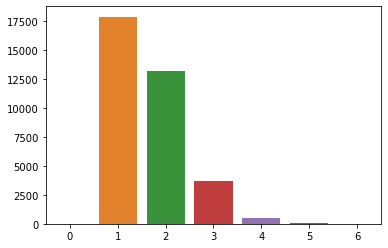

In [121]:
lol = sns.barplot(x=list(range(0,7)), y=n_cells_atlevel)

In [127]:
plt.show(lol)

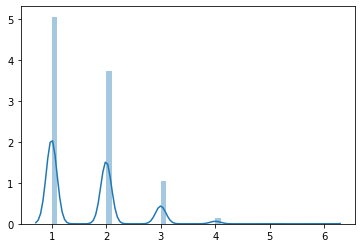

In [96]:
sns.distplot(n_positive)

In [109]:
[sum(n_positive > i).tolist()[0][0] for i in range(0,7)]

[35371, 17471, 4276, 566, 43, 3, 0]

In [98]:
type(adata.X[:,0])

scipy.sparse.csr.csr_matrix

In [99]:
batch_adata.X[:,0]

<35371x1 sparse matrix of type '<class 'numpy.float32'>'
	with 35367 stored elements in Compressed Sparse Row format>

In [100]:
best = [drop_identifier(a=batch_adata.X[x,:],
                              n_top=int(n_positive[x]),
                              bc_ids=batch_adata.var['batch'])
              for x in range(batch_adata.n_obs)]

In [101]:
best_guess = [x['barcodes'] for x in best]
best_exp = [x['expression'] for x in best]

In [102]:
batch_adata.obs['best_guess'] = best_guess
batch_adata.obs['expression'] = best_exp

In [103]:
batch_adata.obs

,n_counts,batch_cluster,assignment,best_guess,expression
AAACCCAAGAAGTCTA-1,3470.0,8,MTP,"(barcode3, barcode2)","(8.64, 8.16)"
AAACCCAAGAGGTCGT-1,2601.0,0,MTP,"(barcode6, barcode9, barcode4)","(8.46, 7.72, 7.69)"
AAACCCAAGCATCCTA-1,905.0,0,MTP,"(barcode6, barcode3)","(8.82, 6.53)"
AAACCCAAGCATTGAA-1,1256.0,5,SNG,"(barcode10,)","(8.85,)"
AAACCCAAGGAAGTGA-1,1587.0,7,MTP,"(barcode5, barcode6)","(8.39, 7.93)"
...,...,...,...,...,...
TTTGTTGTCCATTTGT-1,727.0,7,SNG,"(barcode5,)","(8.67,)"
TTTGTTGTCCCAACTC-1,1541.0,6,SNG,"(barcode7,)","(8.87,)"
TTTGTTGTCCGAGGCT-1,1611.0,6,MTP,"(barcode1, barcode7)","(8.5, 8.21)"
TTTGTTGTCGTTCGCT-1,1016.0,2,SNG,"(barcode1,)","(8.96,)"


In [398]:
a = batch_adata.X[0,:].toarray()[0].tolist()
bc_ids = batch_adata.var['batch'].tolist()

In [408]:
a_ord, bc_ids_ord = zip(*sorted(zip(a, bc_ids), reverse=True))

In [413]:
a_ord[:2]

(8.63879680633545, 8.157093048095703)

In [381]:
batch_adata.var['batch'].tolist()

['barcode1',
 'barcode2',
 'barcode3',
 'barcode4',
 'barcode5',
 'barcode6',
 'barcode7',
 'barcode8',
 'barcode9',
 'barcode10']